In [1]:
# Import the necessary libraries
from core.glacier import GlacierDynamicsCheckpointed
import torch
from core.inversion import inversion_extent,inversion_thicknes
from core.smb import update_smb
from visualization.plots import  visualize_velocities,plot_loss_components
from core.forward_schemes.emulator_step import checkpointed_emulator_step
import matplotlib.pyplot as plt
from torch.utils.checkpoint import checkpoint
from core.cnn_model import CNN
from data.loader import load_geology
import pandas as pd
import numpy as np
import netCDF4


%matplotlib inline

Using device: cuda:1


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [3]:

config = {
"nb_layers": 8,               # Number of convolutional layers
"nb_out_filter": 64,           # Number of output filters for Conv2D
"conv_ker_size": 5,            # Convolution kernel size
"activation": "lrelu",          # Activation function: "relu" or "lrelu"
"dropout_rate": 0.1,           # Dropout rate
}
nb_inputs = 3  # thk, slopsurfx, slopsurfy
nb_outputs = 2  # ubar, vbar
state = torch.load('data/emulator_model.pth', map_location=device, weights_only=False)
model = CNN(nb_inputs, nb_outputs, config).to(device)
model.load_state_dict(state, strict=True)
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Dropout(p=0.1, inplace=False)
    (15): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (16): LeakyReLU(negative_slope=0.01)
    (17): Dropout(p=0.1, inplace=False)
    (18): Conv2d(64, 64, kernel_size=(5, 5), stride=(

In [4]:
import torch
import torch.nn.functional as F

file_path = "temp_prec.dat"

# --- Read & parse file without NumPy/pandas ---
years_f = []
jds_f   = []
temps   = []
precs   = []

with open(file_path, "r") as f:
    lines = f.read().strip().splitlines()

# Skip first 2 header rows
for line in lines[2:]:
    if not line.strip():
        continue
    # Expect 5 columns: year jd hour temp prec
    cols = line.split()
    if len(cols) < 5:
        continue
    y, jd, hr, te, pr = cols[:5]
    years_f.append(float(y))
    jds_f.append(float(jd))
    temps.append(float(te))
    precs.append(float(pr))

# --- Convert to tensors ---
year = torch.tensor(years_f, dtype=torch.float32)
jd   = torch.tensor(jds_f,   dtype=torch.float32)
temp = torch.tensor(temps,   dtype=torch.float32)
prec = torch.tensor(precs,   dtype=torch.float32)

# Cast year & jd to int
year_i = year.to(torch.int64)
jd_i   = jd.to(torch.int64)

# Optional: sort by (year, jd) for tidiness
sort_keys = year_i * 1000 + jd_i
order = torch.argsort(sort_keys)        # not necessarily stable, but fine here
year_i = year_i[order]
jd_i   = jd_i[order]
temp   = temp[order]
prec   = prec[order]

# Unique sorted years and mapping (yidx)
years = torch.unique(year_i, sorted=True)          # shape (num_years,)
yidx  = torch.searchsorted(years, year_i)          # per-row index in [0..num_years-1]

# Day index: clamp to 1..366, then make 0-based
didx = torch.clamp(jd_i, 1, 366) - 1               # 0..365

num_years = years.numel()

# --- Scatter into grids (overwrites if duplicates; set accumulate=True to sum) ---
temp_grid = torch.zeros((num_years, 366), dtype=torch.float32)
prec_grid = torch.zeros((num_years, 366), dtype=torch.float32)

# If you have multiple rows per (year, day) and want to SUM them, use accumulate=True
temp_grid.index_put_((yidx, didx), temp, accumulate=False)
prec_grid.index_put_((yidx, didx), prec, accumulate=False)

# Final tensor: (num_years, 366, 2) with [:, :, 0]=temp, [:, :, 1]=prec
data = torch.stack((temp_grid, prec_grid), dim=-1)

print(data.shape)   # e.g., torch.Size([num_years, 366, 2])
# `years` holds the calendar year labels in order (LongTensor)



torch.Size([152, 366, 2])


In [5]:
def cosine_temperature_series(ttot, t_freq, T_high=9, T_low=7.0, device='cpu'):
    """
    Returns a tensor of length N = ttot / t_freq with one full cosine cycle:
    starts at T_high, dips to T_low mid-cycle, returns to T_high at the end.
    """
    N = int(round(ttot / float(t_freq)))
    if N < 2:
        raise ValueError("ttot/t_freq must be >= 2 to form a cosine cycle.")
    mean = 0.5 * (T_high + T_low)   # 8.0
    amp  = 0.5 * (T_high - T_low)   # 1.0
    theta = torch.linspace(0, 2*torch.pi, steps=N, device=device)  # inclusive of endpoints
    return mean + amp * torch.cos(theta)


In [6]:
Z_topo,H_init, icemask = load_geology("data/geology.nc")

In [7]:
# Z_topo=Z_topo_[100:,:]
# icemask=icemask_[100:,:]


In [8]:
dx=100
dy=100
ttot=torch.tensor(1999.0)
time=torch.tensor(1880.0)
rho, g, fd=1,1,1
precip_tensor=1.3
T_m_lowest=9.0
T_s=10.0

In [9]:
# torch.save(H_sim,'Obs_cosine2.pt')

## Inversion

In [10]:
Lx, Ly = Z_topo.shape[1] * dx, Z_topo.shape[0] * dy

glacier_model = GlacierDynamicsCheckpointed(
        Z_topo,H_init, ttot,time, rho, g, fd,
        Lx, Ly, dx, dy,dtmax=1, device=device, ice_mask=icemask,model=model
    )

In [11]:
# series=cosine_temperature_series(ttot,10.0)
#     # Time axis aligned with the inclusive endpoint above
# time_axis = torch.linspace(0, ttot, steps=series.numel())
# plt.figure()
# plt.plot(time_axis.numpy(), series.cpu().numpy(), marker='o')
# plt.title("Cosine Temperature Series")
# plt.xlabel("Time")
# plt.ylabel("Temperature (°C)")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('Synthetic_temperature.png')
# plt.show()

In [21]:
H26,H57,H80,H99 = glacier_model(precip_tensor, T_m_lowest, T_s,P_daily=data[:,:,1]/1000,T_daily=data[:,:,0]+13.762,melt_factor=3.0500665633007884)  # Use the checkpointed glacier model


In [22]:
# torch.save(H_simulated1,'Obs_cosine1.pt')
# torch.save(H_simulated2,'Obs_cosine2.pt')
0.001271193497814238*365

0.4639856267021969

In [23]:
# print(torch.mean(H_simulated1-obs),torch.mean(H_simulated-obs))
def plot_sim_with_obs_extent(sim, obs, thresh=1.0, obs_is_mask=False,sim_is_mask=False):
    """Plot simulated thickness with observed extent overlaid (blue, filled)."""
    to_np = lambda x: x.detach().cpu().numpy() if hasattr(x, "detach") else np.asarray(x)
    sim_np = to_np(sim)
    obs_np = to_np(obs)

    # extent mask for observations
    obs_mask = obs_np if obs_is_mask else (obs_np > thresh)
    sim_mask = sim_np if sim_is_mask else (sim_np > thresh)


    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(sim_np, origin='lower')  # simulated thickness background
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Thickness [m]')

    # filled observed extent in blue (contourf over the mask)
    ax.contour(
        obs_mask.astype(float),
        levels=[0.5, 1.5],    # fill where mask==1
        colors=['blue'],
        alpha=0.35,
        origin='lower'
    )
    ax.contour(
        sim_mask.astype(float),
        levels=[0.5, 1.5],    # fill where mask==1
        colors=['red'],
        alpha=0.35,
        origin='lower'
    )
    ax.set_title("Simulated thickness with observed extent (blue) ")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()



In [24]:
# obs_thk1 = torch.load('Obs_cosine1.pt',weights_only=True).to(device)
# obs_thk2 = torch.load('Obs_cosine2.pt',weights_only=True).to(device)

In [25]:
# visualize(Z_topo,ttot,obs_thk2,Lx,Ly)

In [26]:

nc = netCDF4.Dataset('./data/geology.nc')
topo = torch.tensor(nc.variables['topg'][:], device=device)
obs_26= torch.tensor(nc.variables['surf_1926'][:], device=device) -topo
obs_57= torch.tensor(nc.variables['surf_1957'][:], device=device) -topo
obs_80= torch.tensor(nc.variables['surf_1980'][:], device=device) -topo
obs_99= torch.tensor(nc.variables['surf_1999'][:], device=device) -topo
nc.close()



In [27]:
print(f"Difference {torch.sum(H26-obs_26)/torch.sum(obs_26) *100} ")
print(f"Difference {torch.sum(H57-obs_57)/torch.sum(obs_57) *100} ")
print(f"Difference {torch.sum(H80-obs_80)/torch.sum(obs_80) *100} ")
print(f"Difference {torch.sum(H99-obs_99)/torch.sum(obs_99) *100} ")


Difference -105.42221069335938 
Difference -85.34114074707031 
Difference -131.52365112304688 
Difference -92.60884094238281 


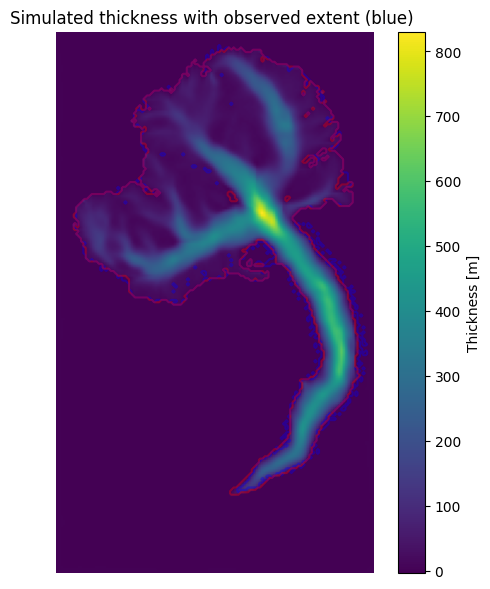

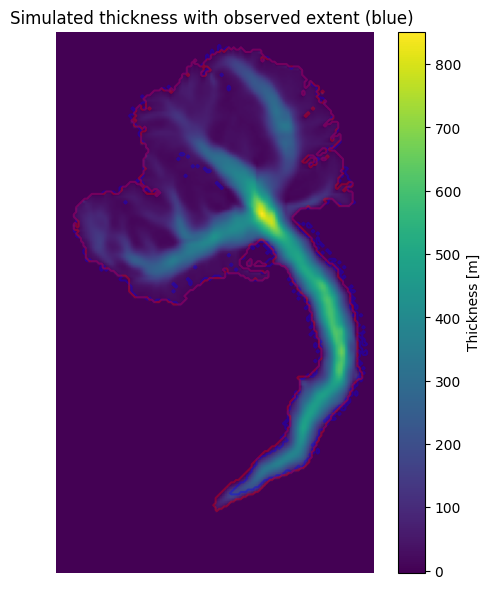

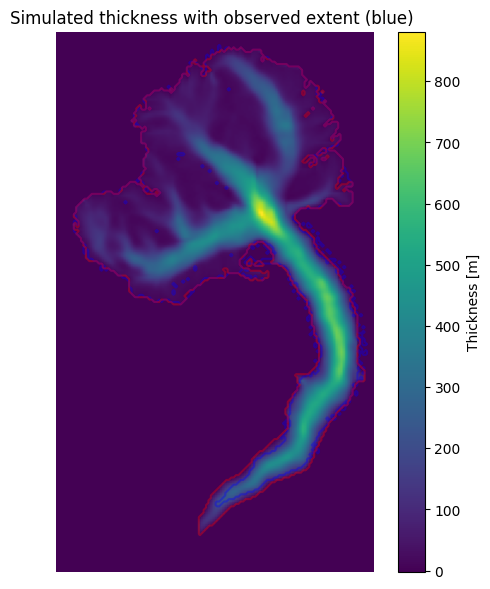

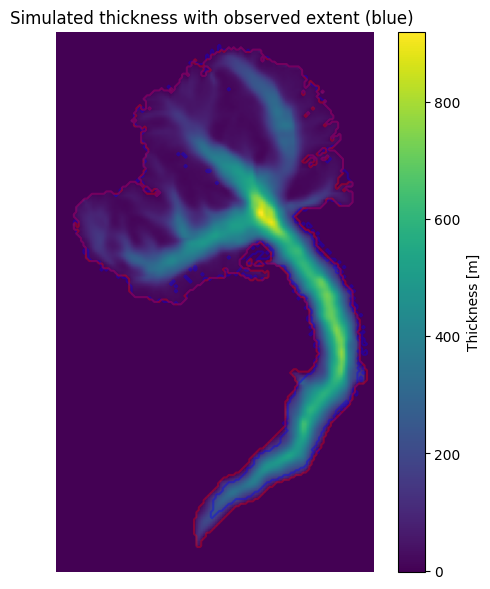

In [19]:
plot_sim_with_obs_extent(sim=H99, obs=obs_99, thresh=1.0)   
plot_sim_with_obs_extent(sim=H80, obs=obs_80, thresh=1.0)   
plot_sim_with_obs_extent(sim=H57, obs=obs_57, thresh=1.0)   
plot_sim_with_obs_extent(sim=H26, obs=obs_26, thresh=1.0)  


Iter 1: loss=13098.87305, melt factor=1.5364998928271234/365 difference = 10.15440845489502 

Iter 2: loss=12762.81250, melt factor=1.5729926922358572/365 difference = 9.612616539001465 

Iter 3: loss=12444.13379, melt factor=1.6094739339314401/365 difference = 9.113801002502441 

Iter 4: loss=12113.36328, melt factor=1.6459386888891459/365 difference = 8.635498046875 

Iter 5: loss=11768.13965, melt factor=1.6823838977143168/365 difference = 8.062655448913574 

Iter 6: loss=11465.36230, melt factor=1.7188000422902405/365 difference = 7.6083292961120605 

Iter 7: loss=11177.51465, melt factor=1.7551827034913003/365 difference = 7.116486549377441 

Iter 8: loss=10851.95605, melt factor=1.7915250826627016/365 difference = 6.534991264343262 

Iter 9: loss=10534.53125, melt factor=1.8278219108469784/365 difference = 5.982877254486084 

Iter 10: loss=10263.25195, melt factor=1.864067919086665/365 difference = 5.45236349105835 

Iter 11: loss=9922.07812, melt factor=1.9002522295340896/365 d

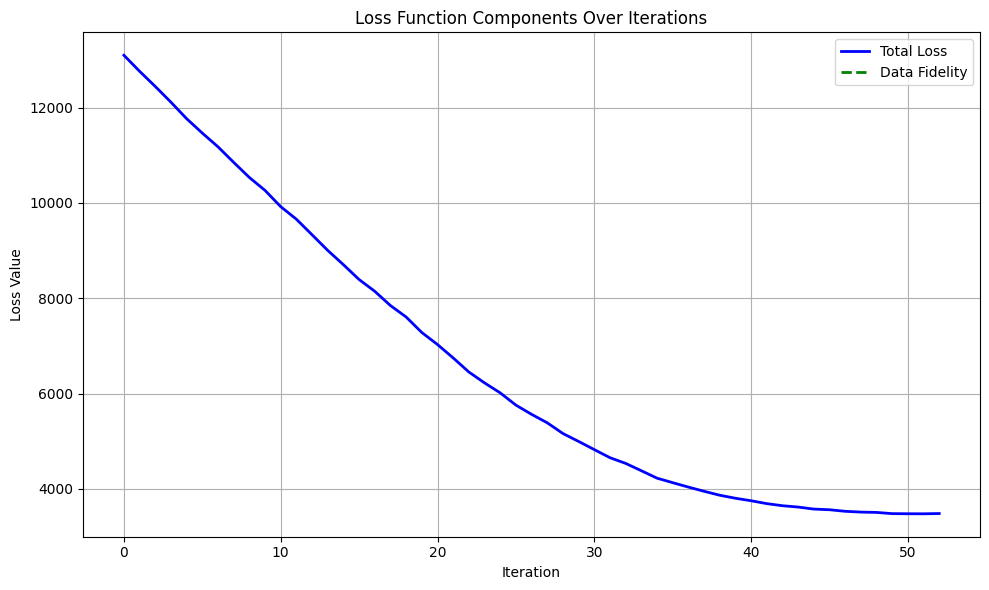

In [20]:
# Early stopping parameters
early_stop_patience = 1
early_stop_threshold = 1e-5
# Internal early stopping stateobs
best_loss = float('inf')
no_improve_count = 0

# _,obs, _ = load_geology("data/geology.nc")


# # precip_tensor = torch.full(Z_topo.shape,1.3,requires_grad=False,device=device)
# precip_tensor = torch.tensor(precip_tensor,requires_grad=False,device=device)
# T_m_lowest = torch.full((20,1),7.0, requires_grad=True, device=device)
# T_s = torch.tensor(10.0, requires_grad=False, device=device)

P_daily_=data[:,1]/1000
T_daily_=data[:,0]+13.762
melt_factor= torch.tensor(1.5/365, requires_grad=True, device=device)


optimizer = torch.optim.Adam([melt_factor], lr=0.0001)
loss_hist, Precip_history, data_hist = [], [], []
results = []
for i in range(100):  # n_iterations
    optimizer.zero_grad()
    
    # # Force positivity with softplus
    # melt_factor = F.relu(melt_factor_raw)

    H_simulated, loss = inversion_thicknes(P_daily=data[:,:,1]/1000,T_daily=data[:,:,0]+13.762, melt_factor=melt_factor,obs26=obs_26 ,obs57=obs_57 ,obs80=obs_80 ,obs99=obs_99 , glacier_model=glacier_model,reg_lambda=0.02
    )
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
    Precip_history.append(melt_factor.item())
    # print(f"Iter {i+1}: loss={loss:.5f}, extent={data_fidelity:.5f} precip={precip_tensor.mean().item():.3f}, T={T_m_lowest.mean().item():.3f}")
    print(f"Iter {i+1}: loss={loss:.5f}, melt factor={melt_factor.item()*365}/365 difference = {torch.mean(H_simulated-obs_99)} ")

    # Early stopping check
    if i>1:
        if best_loss - loss.item() > early_stop_threshold:
            best_loss = loss.item()
            no_improve_count = 0
        else:
            no_improve_count += 1
            print(f"No significant improvement for {no_improve_count} iteration(s).")
        if no_improve_count >= early_stop_patience:
            print(f"1 Early stopping triggered at iteration {i + 1}.")
            break
        if loss.item() <= 0.001:
            print(f"2 Early stopping triggered at iteration {i + 1}.")
            break
    
#     results.append(f"Iter {i+1}: loss={loss:.3f}, precip={precip_tensor.mean().item():.3f}, T={T_m_lowest.mean().item():.3f}")
# # plot_gradient_evolution(grads, f"grad_{tag}.png")
plot_loss_components(loss_hist,data_hist, f"loss_kot.png")
# torch.save(precip_tensor,f'Recon_Precip.pt')
# torch.save(H_simulated,f'Recon_Glac.pt')
      



In [ ]:
0.0011539302067831159 *365

In [ ]:
plt.figure(2)
plt.title("Reconstructed Temperature")
plt.plot(time_axis.numpy(),T_m_lowest.detach().cpu().numpy())
plt.xlabel('Time [years]')
plt.ylabel('Mean Anual Temperature [degree C]')
plt.savefig('reconstructed_temperature')
plt.show()


In [ ]:
# Plot both in one figure
plt.figure()
plt.plot(time_axis.numpy(), series.cpu().numpy(), marker='o', label='Synthetic temperature')
plt.plot(time_axis.numpy(), T_m_lowest.detach().cpu().numpy(), label='Reconstructed temperature')
# Add a red star at t=200, temp=9.0
print([200], [9.0], marker='*', markersize=14, color='red', label='Observstion1')
print([175], [8.72], marker='*', markersize=14, color='orange', label='Observstion2')

plt.title("Temperature Series Comparison")
plt.xlabel("Time [years]")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("temperatures_comparison.png")
plt.show()

## Make a figure that justifies why we should invert for temperature and not precipitation


In [ ]:
# Load the file (the user mentioned skiprows=2 and known column order)
file_path = "temp_prec.dat"

# Load with numpy
arr = np.loadtxt(file_path, dtype=np.float32, skiprows=2)

# Create dataframe
df = pd.DataFrame(arr, columns=["year", "jd", "hour", "temp", "prec"])

In [ ]:
# Ensure types are clean
df["year"] = df["year"].astype(int)
df["jd"]   = df["jd"].astype(int)

# Sort just to be tidy
df = df.sort_values(["year", "jd"], kind="mergesort")

# Get the list of years in order and a mapping to indices
years = np.sort(df["year"].unique())
year_to_idx = {y: i for i, y in enumerate(years)}

# Initialize output: (n_years, 366 days, 2 vars [temp, prec])
out = np.zeros((len(years), 366, 2), dtype=np.float32)

# Clip JD to 1..366 just in case (optional safety)
jd = df["jd"].to_numpy()
jd = np.clip(jd, 1, 366)

# Vectorized placement:
yidx = df["year"].map(year_to_idx).to_numpy()
didx = jd - 1  # 0-based day index

out[yidx, didx, 0] = df["temp"].to_numpy(dtype=np.float32)  # temperature
out[yidx, didx, 1] = df["prec"].to_numpy(dtype=np.float32)  # precipitation

print(out.shape)   # should be (len(years), 366, 2)

In [ ]:
plt.figure()
# print(out[-1,:,1])
plt.plot(out[1,:,0]+18.0)
plt.plot(out[1,:,0]+11.0)
plt.plot(out[1,:,0]+4.0)
plt.plot(out[1,:,0])
plt.axhline(0, linestyle='--', linewidth=1)



In [ ]:
print((out[1,:,1]).sum())
print((out[2,:,1]).sum())
print((out[3,:,1]).sum())
print((out[4,:,1]).sum())


In [ ]:
thr=0.2


print(1.5/365*torch.clamp((out[1,:,0]+18.0) - thr, min=0).sum())
print(2/365*torch.clamp((out[1,:,0]+11.0) - thr, min=0).sum())
print(2/365*torch.clamp((out[1,:,0]+4.0) - thr, min=0).sum())
print(2/365*torch.clamp((out[1,:,0]) - thr, min=0).sum())


In [ ]:
print(df.head())

In [ ]:
# For rolling averages, choose window (e.g., 30 samples)
window = 30
df["temp_roll"] = df["temp"].rolling(window, center=True).mean()
df["prec_roll"] = df["prec"].rolling(window, center=True).mean()

# Create a time index (approximate: year + jd/365 + hour/8760)
time_index = df["year"] + (df["jd"] - 1)/365.0 + df["hour"]/8760.0

# Temperature figure
plt.figure(figsize=(10,4))
color = "C0"
plt.plot(time_index, df["temp"], color=color, alpha=0.6, label="Temperature")
plt.plot(time_index, df["temp_roll"], color=color, linewidth=2.5, label="Rolling Avg")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.title("Temperature Evolution")
plt.show()

# Precipitation figure
plt.figure(figsize=(10,4))
color = "C1"
plt.plot(time_index, df["prec"], color=color, alpha=0.6, label="Precipitation")
plt.plot(time_index, df["prec_roll"], color=color, linewidth=2.5, label="Rolling Avg")
plt.xlabel("Year")
plt.ylabel("Precipitation")
plt.legend()
plt.title("Precipitation Evolution")
plt.show()


In [ ]:
# and now using yearly temperature average
# Compute yearly averages for temp and prec
yearly = df.groupby("year").agg(
    temp_mean=("temp", "mean"),
    prec_mean=("prec", "mean")
).reset_index()

# Rolling averages on yearly data (e.g., 5-year window)
window = 5
yearly["temp_roll"] = yearly["temp_mean"].rolling(window, center=True).mean()
yearly["prec_roll"] = yearly["prec_mean"].rolling(window, center=True).mean()

# Create subplots that share the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# Temperature
color = "C0"
ax1.plot(yearly["year"], yearly["temp_mean"], color=color, alpha=0.6, label="Annual Mean Temp")
ax1.plot(yearly["year"], yearly["temp_roll"], color=color, linewidth=2.5, label="Rolling Avg")
ax1.set_ylabel("Temperature")
ax1.set_title("Temperature Evolution")
ax1.legend()

# Precipitation
color = "C1"
ax2.plot(yearly["year"], yearly["prec_mean"], color=color, alpha=0.6, label="Annual Mean Prec")
ax2.plot(yearly["year"], yearly["prec_roll"], color=color, linewidth=2.5, label="Rolling Avg")
ax2.set_ylabel("Precipitation")
ax2.set_title("Precipitation Evolution")
ax2.legend()

# Shared x-axis label
ax2.set_xlabel("Year")

plt.tight_layout()
plt.savefig('temp_prec_evolution.png')
plt.show()


In [ ]:
print(df.columns.values)

In [ ]:
7